   # Simulateur de crédit 

### 1/ Data cleaning

In [67]:
#Importer les packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

PATH="./datasets/"
test_file = "datasets_137197_325031_test_Y3wMUE5_7gLdaTN.csv"
train_file = "datasets_137197_325031_train_u6lujuX_CVtuZ9i.csv" 

In [7]:
df = pd.read_csv(PATH+train_file)
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [8]:
#commande pour afficher l'espace d'affichage en notebook
    #pd.set_option('display.max_rows',df.shape[0]+1)
    #pd.set_option('display.max_rows',10) : pour afficher uniquement dix lignes

In [9]:
df.info() 
#Partout ou le nombre est inférieur au nombre d'entrées, il y a potentiellement des valeurs manquantes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
Loan_ID              614 non-null object
Gender               601 non-null object
Married              611 non-null object
Dependents           599 non-null object
Education            614 non-null object
Self_Employed        582 non-null object
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
LoanAmount           592 non-null float64
Loan_Amount_Term     600 non-null float64
Credit_History       564 non-null float64
Property_Area        614 non-null object
Loan_Status          614 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [10]:
#Les valeurs manquantes (variables rangées par ordre de nombre de valeurs manquantes)
df.isnull().sum().sort_values(ascending=False)

Credit_History       50
Self_Employed        32
LoanAmount           22
Dependents           15
Loan_Amount_Term     14
Gender               13
Married               3
Loan_Status           0
Property_Area         0
CoapplicantIncome     0
ApplicantIncome       0
Education             0
Loan_ID               0
dtype: int64

In [20]:
#valeurs aberrantes 
df.describe(include='O') #include='O' pour les valeurs catégorielles

#df.describe

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
count,614,601,611,599,614,582,614,614
unique,614,2,2,4,2,2,3,2
top,LP002874,Male,Yes,0,Graduate,No,Semiurban,Y
freq,1,489,398,345,480,500,233,422


In [38]:
#Renseigner les valeurs manquantes
#séparer en sous bases catégorielle et numérique
cat_data=[]
num_data=[]
for i,c in enumerate(df.dtypes):
    if c == object:
        cat_data.append(df.iloc[:,i])
    else:
        num_data.append(df.iloc[:,i])

#transformer en dataframe
cat_data=pd.DataFrame(cat_data).transpose() 
num_data=pd.DataFrame(num_data).transpose() 

In [39]:
#Var catégorielles: remplacer les valeurs manquantes par les modes 
cat_data=cat_data.apply(lambda x:x.fillna(x.value_counts().index[0]))

cat_data.isnull().sum().any() #pour vérifier s'il y a encore de valeur manquante. doit obtenir false

False

In [40]:
#Var numériques: remplacer les valeurs manquantes par les valeurs juste à coté
num_data.fillna(method='bfill', inplace=True) #index[0] parce qu'il mer a chaque fois le mode en premier
num_data.isnull().sum().any()


False

In [41]:
#remplacer les modalités de la variable cible par 0 et 1 au lieu de Y et N
target_value={'Y':1,'N':0}
target=cat_data['Loan_Status']
cat_data.drop('Loan_Status', axis=1, inplace=True)
target=target.map(target_value)
target

0      1
1      0
2      1
3      1
4      1
      ..
609    1
610    1
611    1
612    1
613    0
Name: Loan_Status, Length: 614, dtype: int64

In [43]:
#Faire pareil pour toutes les autres variables catégorielles
#on peut le faire automatiquement avec scikit learn
le = LabelEncoder()
for i in cat_data:
    cat_data[i] = le.fit_transform(cat_data[i])
cat_data


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area
0,0,1,0,0,0,0,2
1,1,1,1,1,0,0,0
2,2,1,1,0,0,1,2
3,3,1,1,0,1,0,2
4,4,1,0,0,0,0,2
...,...,...,...,...,...,...,...
609,609,0,0,0,0,0,0
610,610,1,1,3,0,0,0
611,611,1,1,1,0,0,2
612,612,1,1,2,0,0,2


In [44]:
#supprimer loan_id car inutile
cat_data.drop('Loan_ID', axis=1,inplace=True)

In [45]:
# Concaténer cat_data et num_data pour avoir une seule base et spécifier la colonne target
X=pd.concat([cat_data,num_data],axis=1)
Y=target

In [49]:
X

,Gender,Married,Dependents,Education,Self_Employed,Property_Area,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
0,1,0,0,0,0,2,5849.0,0.0,128.0,360.0,1.0
1,1,1,1,0,0,0,4583.0,1508.0,128.0,360.0,1.0
2,1,1,0,0,1,2,3000.0,0.0,66.0,360.0,1.0
3,1,1,0,1,0,2,2583.0,2358.0,120.0,360.0,1.0
4,1,0,0,0,0,2,6000.0,0.0,141.0,360.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
609,0,0,0,0,0,0,2900.0,0.0,71.0,360.0,1.0
610,1,1,3,0,0,0,4106.0,0.0,40.0,180.0,1.0
611,1,1,1,0,0,2,8072.0,240.0,253.0,360.0,1.0
612,1,1,2,0,0,2,7583.0,0.0,187.0,360.0,1.0


### 2/ Analyse exploratoire

In [50]:
# On va commencer par target, la variable cible
target.value_counts()

1    422
0    192
Name: Loan_Status, dtype: int64

In [53]:
#la base complète
df = pd.concat([cat_data,num_data,target],axis=1)

le pourcentage des crédits accordés est: 0.3127035830618892
le pourcentage des crédits non accordés est: 0.6872964169381107


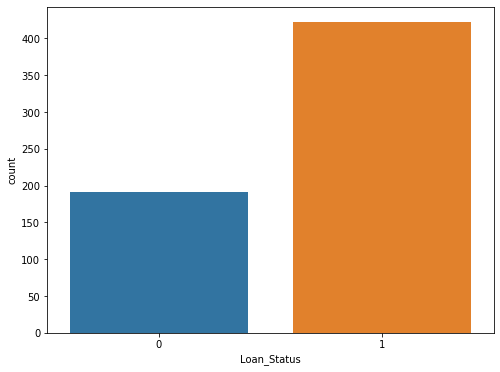

In [54]:
plt.figure(figsize=(8,6))
sns.countplot(target)
yes=target.value_counts()[0]/len(target)
no=target.value_counts()[1]/len(target)
print(f'le pourcentage des crédits accordés est: {yes}')
print(f'le pourcentage des crédits non accordés est: {no}')


/home/maa/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


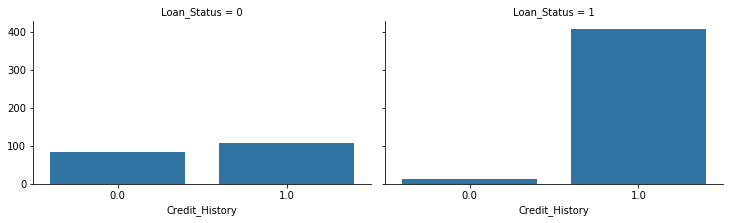

In [56]:
# Credit history
grid=sns.FacetGrid(df,col='Loan_Status',size=3.2, aspect=1.6)
grid.map(sns.countplot,'Credit_History')

#On retient du graphe, que lorsque tu as un historique de crédits, tu as bcp de chances que ton crédit soit accepté


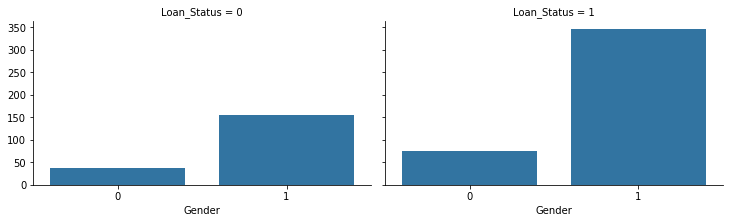

In [57]:
# sexe
grid=sns.FacetGrid(df,col='Loan_Status',size=3.2, aspect=1.6)
grid.map(sns.countplot,'Gender')

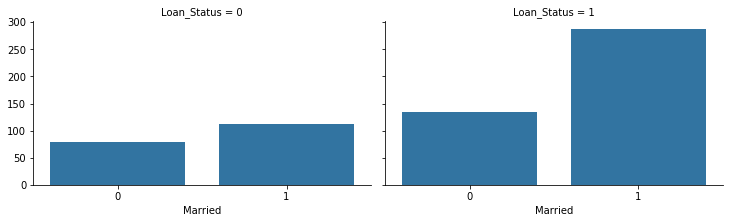

In [58]:
# marié ou pas
grid=sns.FacetGrid(df,col='Loan_Status',size=3.2, aspect=1.6)
grid.map(sns.countplot,'Married')

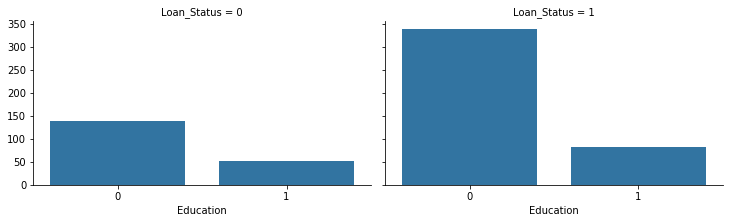

In [59]:
# Education
grid=sns.FacetGrid(df,col='Loan_Status',size=3.2, aspect=1.6)
grid.map(sns.countplot,'Education')

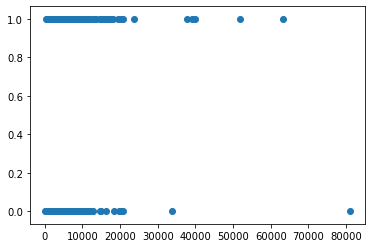

In [60]:
# Revenu du demandeur
plt.scatter(df['ApplicantIncome'],df['Loan_Status'])

#visiblement, pas de lien 

In [61]:
df.groupby('Loan_Status').median()

,Gender,Married,Dependents,Education,Self_Employed,Property_Area,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
Loan_Status,,,,,,,,,,,
0,1,1,0,0,0,1,3833.5,268.0,132.5,360.0,1.0
1,1,1,0,0,0,1,3812.5,1239.5,127.5,360.0,1.0


### 3/ Réalisation du modèle

In [65]:
# Scinder en train et test

sss = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train, test in sss.split(X,Y):
    X_train,X_test=X.iloc[train],X.iloc[test]
    y_train,y_test=Y.iloc[train],Y.iloc[test]
    
print('X_train taille: ', X_train.shape)
print('X_test taille: ', X_test.shape)
print('y_train taille: ', y_train.shape)
print('y_test taille: ', y_test.shape)

X_train taille:  (491, 11)
X_test taille:  (123, 11)
y_train taille:  (491,)
y_test taille:  (123,)


In [71]:
# On va essayer 3 modèles et après évaluation, faire un choix: Regression logistique, KNN, DecisionTree
models = {
    'LogisticRegression': LogisticRegression(random_state=42),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(max_depth=1, random_state=42)
}

#La fonction de précision

def accu(y_true,y_pred, retu=False):
    acc = accuracy_score(y_true,y_pred)
    if retu:
        return acc
    else:
        print(f'La précision demandée est: {acc}')

#Fonction d'application des modèles
def train_test_eval(models, X_train, y_train, X_test, y_test):
    for name,model in models.items():
        print(name,':')
        model.fit(X_train, y_train)
        accu(y_test,model.predict(X_test))
        print('-'*30)
        
train_test_eval(models,X_train, y_train, X_test, y_test)
             

LogisticRegression :
La précision demandée est: 0.8536585365853658
------------------------------
KNeighborsClassifier :
La précision demandée est: 0.6504065040650406
------------------------------
DecisionTreeClassifier :
La précision demandée est: 0.8455284552845529
------------------------------


/home/maa/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pour avoir la réponse de la banque il nous faut 11 variables. On va essayer de travailler avec les variables les plus pertinentes pour faciliter le passage à l'application

In [86]:
# Ainsi, on va faire un extrait de la base et appliquer le modèle dessus
X_2=X[['Credit_History','Married','CoapplicantIncome']]


In [87]:
X_2.head()

,Credit_History,Married,CoapplicantIncome
0,1.0,0,0.0
1,1.0,1,1508.0
2,1.0,1,0.0
3,1.0,1,2358.0
4,1.0,0,0.0


In [88]:
# Scinder en train et test

sss = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train, test in sss.split(X_2,Y):
    X_train,X_test=X_2.iloc[train],X_2.iloc[test]
    y_train,y_test=Y.iloc[train],Y.iloc[test]
    
print('X_train taille: ', X_train.shape)
print('X_test taille: ', X_test.shape)
print('y_train taille: ', y_train.shape)
print('y_test taille: ', y_test.shape)
print('\n'*2)

train_test_eval(models,X_train, y_train, X_test, y_test) #le meilleur est celui de le regression logistique

X_train taille:  (491, 3)
X_test taille:  (123, 3)
y_train taille:  (491,)
y_test taille:  (123,)



LogisticRegression :
La précision demandée est: 0.8536585365853658
------------------------------
KNeighborsClassifier :
La précision demandée est: 0.6991869918699187
------------------------------
DecisionTreeClassifier :
La précision demandée est: 0.8455284552845529
------------------------------


### 4/ Déploiement du modèle (Flask)

In [89]:
# Appliquer la régression logistique sur notre bdd

Classifier = LogisticRegression()
Classifier.fit(X_2,Y)


LogisticRegression()

In [90]:
# save model

pickle.dump(Classifier,open('model.pkl','wb'))

In [ ]:
#suite dans dossier deploiement